In [3]:
# from circuit_suite import circuits
# # from backend_suite import backends, large_backends, shuffle_test, routing_test
# #from backend_suite import placement_test

In [4]:
# from backend_suite import backends
# backends["Hatlab-Large-Riswap-Dense"].pass_manager.run(circuits["QFT"].circuit_lambda(4))

## Circuit Transpile Benchmark

In [1]:
#make a plot :)
import matplotlib.pyplot as plt

def benchmark(backends, circuit_generator, q_range=None, continuously_save=False, overwrite=False):
    #override qrange if provided
    if q_range is None:
        q_range = circuit_generator.q_range
    
    #check if data dicts are empty
    for backend in backends:
        if not circuit_generator.label in backend.data.keys():
            backend.data[circuit_generator.label] = {}
            backend.data[circuit_generator.label]["duration"] = {}
            backend.data[circuit_generator.label]["gate_count"] = {}
            backend.data[circuit_generator.label]["gate_count_crit"] = {}
            backend.data[circuit_generator.label]["layout_score"] = {}

    #outer loop over circuit since this may take long time to generate
    for q in q_range:
        #create new variable sized lambda circuit

        #wait to build circuit (may be costly), if we end up not needing it for any backend
        qc = None
        if overwrite:
            qc = circuit_generator.circuit_lambda(q)

        for backend in backends:
            
            #condition to skip
            if not overwrite:
                #convert to int because if loaded from json key will be a string
                if q in [int(k) for k in backend.data[circuit_generator.label]["gate_count"].keys()]:
                    continue

            #resolve wait
            if qc is None:
                qc = circuit_generator.circuit_lambda(q)

            #logging.info(f"Transpiler qc{q} for {backend.label}")
            print(f"Transpiler qc{q} for {backend.label}")
            backend.pass_manager.run(qc)

            #save data to dict
            #might be empty if not decomposing swaps
            if "duration_longest_path_length" in backend.pass_manager.property_set.keys():
                duration = backend.pass_manager.property_set["duration_longest_path_length"]
                backend.data[circuit_generator.label]["duration"][q] = float(duration)
            
            gate_count = backend.pass_manager.property_set["count_ops"]
            backend.data[circuit_generator.label]["gate_count"][q] = gate_count

            gate_count_critical_path = backend.pass_manager.property_set["count_ops_longest_path"]
            backend.data[circuit_generator.label]["gate_count_crit"][q] = gate_count_critical_path

            layout_score = backend.pass_manager.property_set["layout_score"]
            backend.data[circuit_generator.label]["layout_score"][q] = float(layout_score)

            #for long tests, may want to save more regularly in case exit early
            if continuously_save:
                backend.save_json()
                
    for backend in backends:
        #save dict to json
        backend.save_json()

In [2]:
#FIXME, use figure to handle subplots
def plot(backends, circuit_label):
    fig, (ax2, ax3) = plt.subplots(1,2, figsize=(24,8))
    for backend in backends:
        if circuit_label in backend.data.keys():
            
            # #duration
            # x = backend.data[circuit_label]["duration"].keys()
            # x = [int(el) for el in list(x)]
            # y = backend.data[circuit_label]["duration"].values()
            # x, y = zip(*sorted(zip(x, y)))
            # ax1.plot(x, y, '-o', label=backend.label)
            # ax1.set_ylabel("crit path normalized pulse duration")
            # ax1.set_xlabel(circuit_label)
            # ax1.legend()
        
            #total swap gates
            x = backend.data[circuit_label]["gate_count"].keys()
            x = [int(el) for el in list(x)]
            y = backend.data[circuit_label]["gate_count"].values()
            x, y = zip(*zip(x, y))
            y = [el['swap'] if 'swap' in el.keys() else 0 for el in y]
            x,y = zip(*sorted(zip(x,y)))
            ax2.plot(x, y, '-o', label=backend.label)
            ax2.set_ylabel("Total SWAP Count")
            ax2.set_xlabel("Circuit Width")
            ax2.legend()
            ax2.set_title("Total Swap vs Width")
    
            #critical path swap gates
            x = backend.data[circuit_label]["gate_count_crit"].keys()
            x = [int(el) for el in list(x)]
            y = backend.data[circuit_label]["gate_count_crit"].values()
            x, y = zip(*zip(x, y))
            y = [el['swap'] if 'swap' in el.keys() else 0 for el in y]
            x,y = zip(*sorted(zip(x,y)))
            ax3.plot(x, y, '-o', label=backend.label)
            ax3.set_ylabel("Critical Path SWAP Count")
            ax3.set_xlabel("Circuit Width")
            ax3.set_title("Critical Swap vs Width")
            ax3.legend()

    fig.suptitle(circuit_label, fontsize=32)
    #savefig
    filename = f"images/{circuit_label}"
    import os
    i = 0
    while os.path.exists('{}{:d}.png'.format(filename, i)):
        i += 1
    fig.savefig('{}{:d}.png'.format(filename, i), facecolor='white')

#plot(placement_test, circuit_gen.label, parameter="duration")
#plot(routing_test, circuit_gen.label, parameter="layout_score")

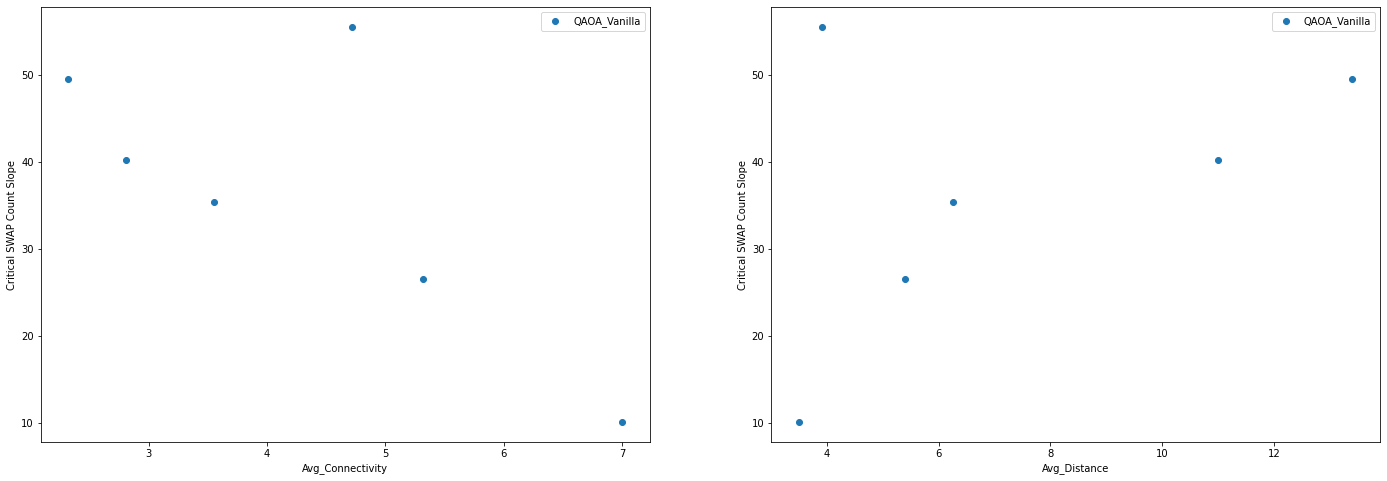

In [34]:
#try and do some data analysis
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

# for circuit_label in circuits.keys():
for circuit_label in ["QAOA_Vanilla"]:
    slope_list = []
    backend_property1 = []
    backend_property2 = []
    for backend in topology_backends:
        x = backend.data[circuit_label]["gate_count_crit"].keys()
        x = [int(el) for el in list(x)]
        y = backend.data[circuit_label]["gate_count_crit"].values()
        x, y = zip(*zip(x, y))
        y = [el['swap'] if 'swap' in el.keys() else 0 for el in y]
        x,y = zip(*sorted(zip(x,y)))
        from scipy.stats import linregress
        slope_list.append(linregress(x, y).slope)
        backend_property1.append(backend.data["Avg_Connectivity"]) #Diameter, Avg_Distance, Avg_Connectivity
        backend_property2.append(backend.data["Avg_Distance"])

    ax1.scatter(backend_property1, slope_list, label=circuit_label)
    ax2.scatter(backend_property2, slope_list, label=circuit_label)
    
ax1.set_xlabel("Avg_Connectivity")
ax1.set_ylabel("Critical SWAP Count Slope")
ax2.set_ylabel("Critical SWAP Count Slope")
ax2.set_xlabel("Avg_Distance")

ax1.legend()
ax2.legend()

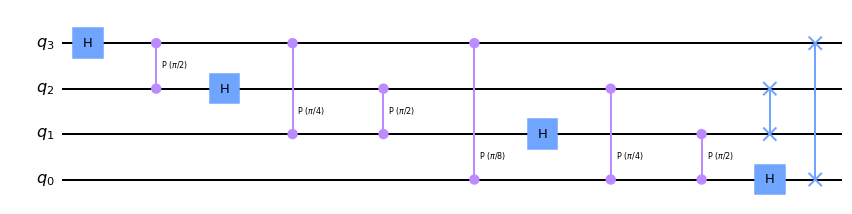

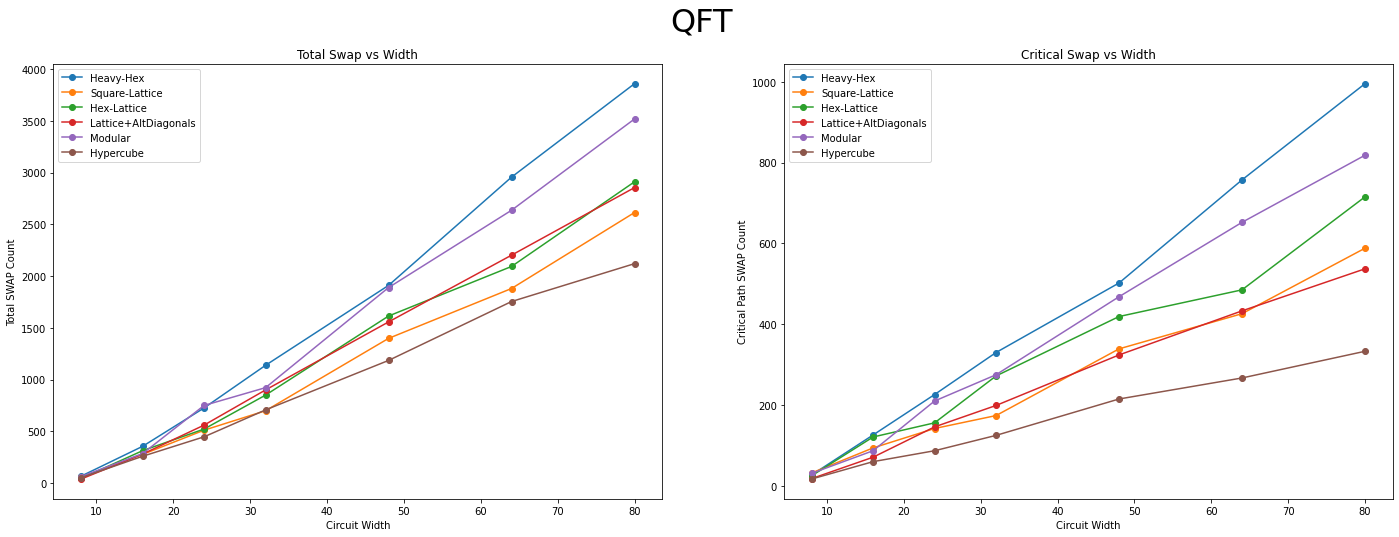

In [13]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits
circuit_gen = circuits["QFT"]
benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
plot(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)

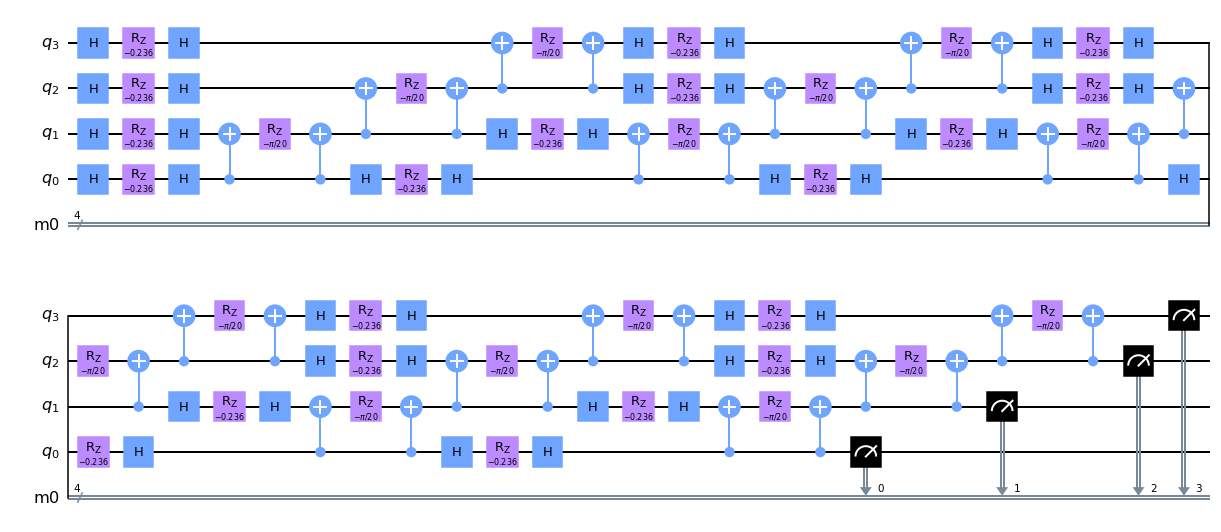

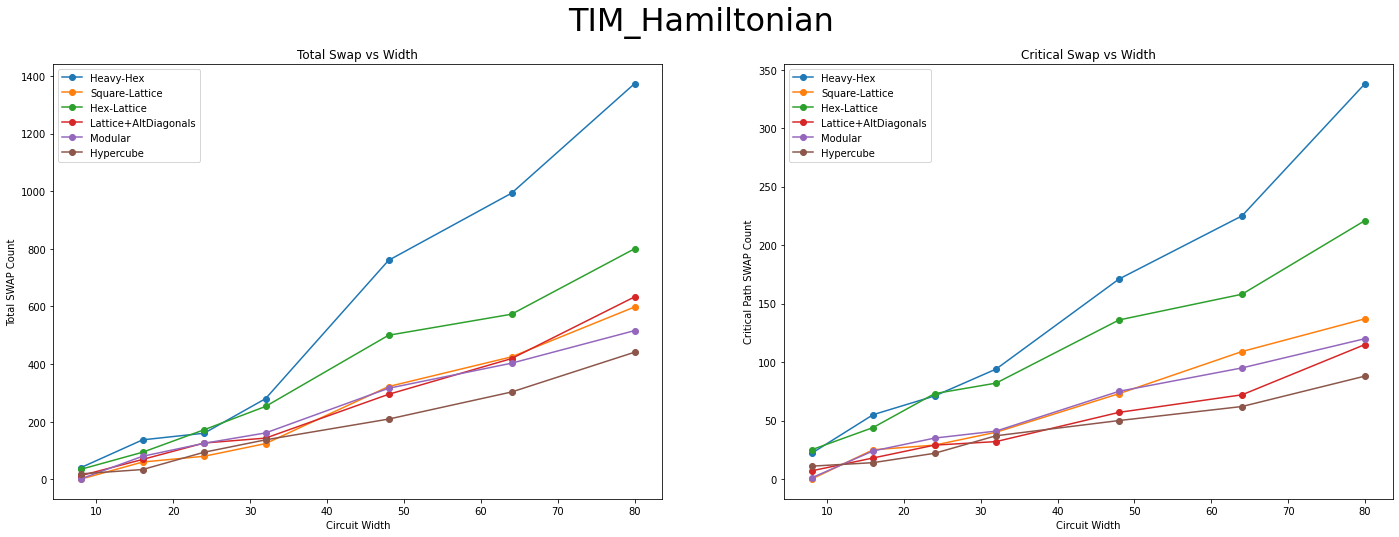

In [12]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits
circuit_gen = circuits["TIM_Hamiltonian"]
benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True)
plot(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output='mpl', reverse_bits=True)

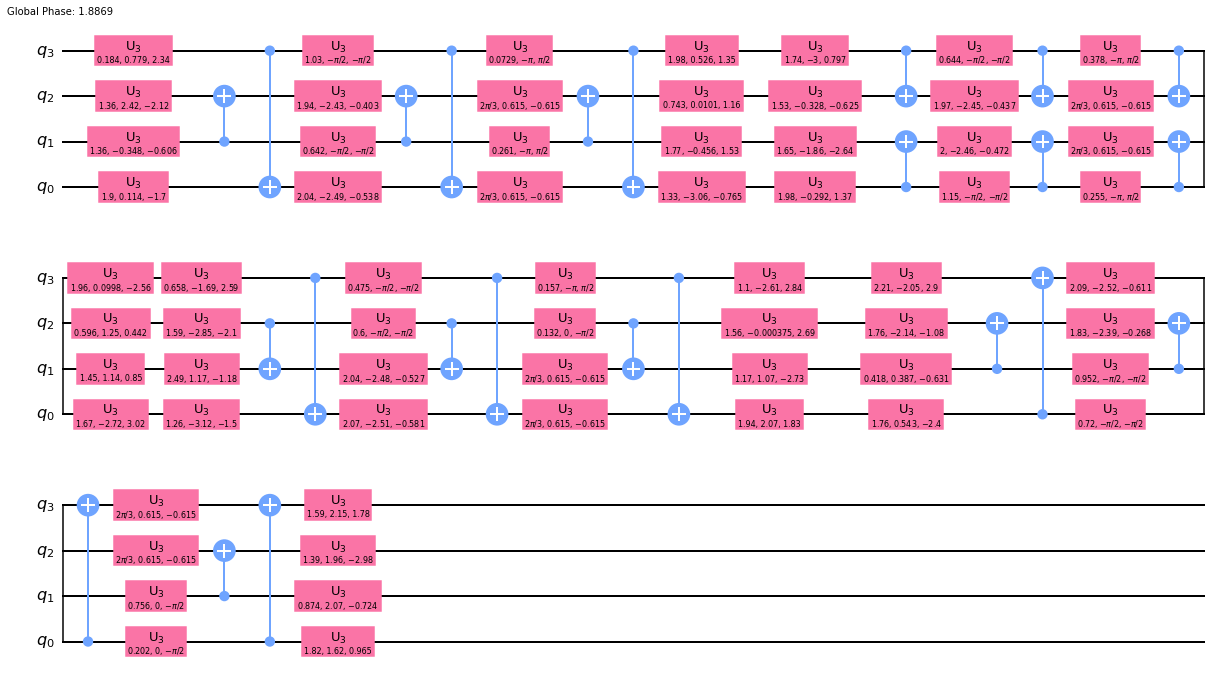

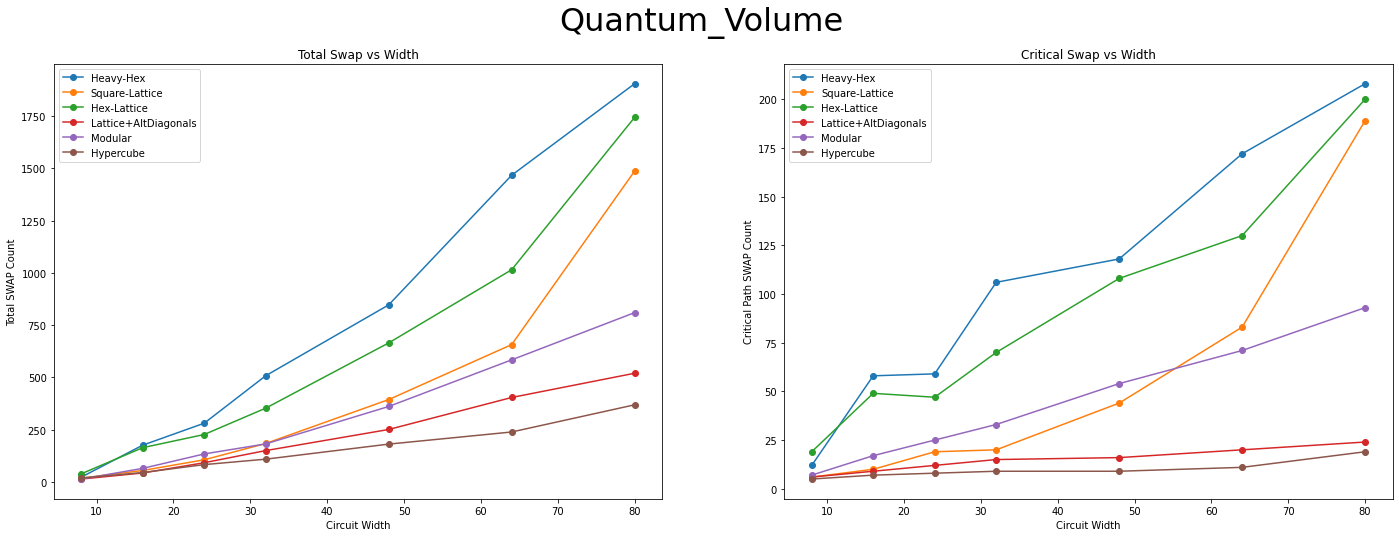

In [16]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits
circuit_gen = circuits["Quantum_Volume"]
benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True)
plot(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).decompose().decompose().draw(output='mpl', reverse_bits=True)

Transpiler qc8 for Modular-RR
Transpiler qc16 for Modular-RR
Transpiler qc24 for Modular-RR
Transpiler qc32 for Modular-RR
Transpiler qc48 for Modular-RR
Transpiler qc64 for Modular-RR
Transpiler qc80 for Modular-RR


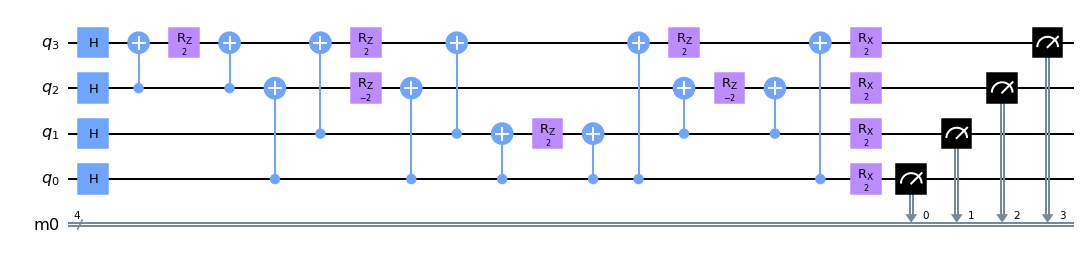

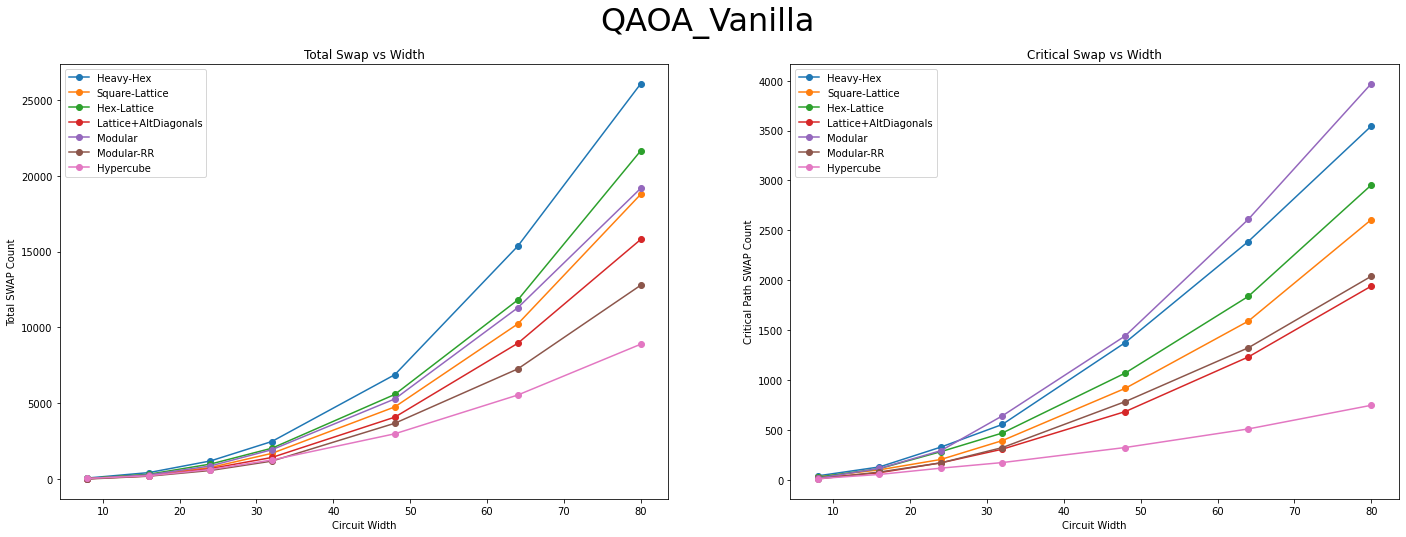

In [3]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits
circuit_gen = circuits["QAOA_Vanilla"]
benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True)
plot(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output='mpl', reverse_bits=True)

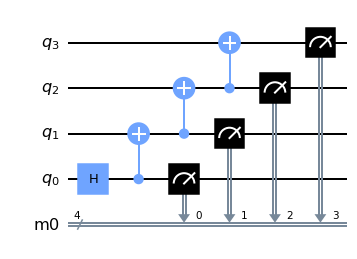

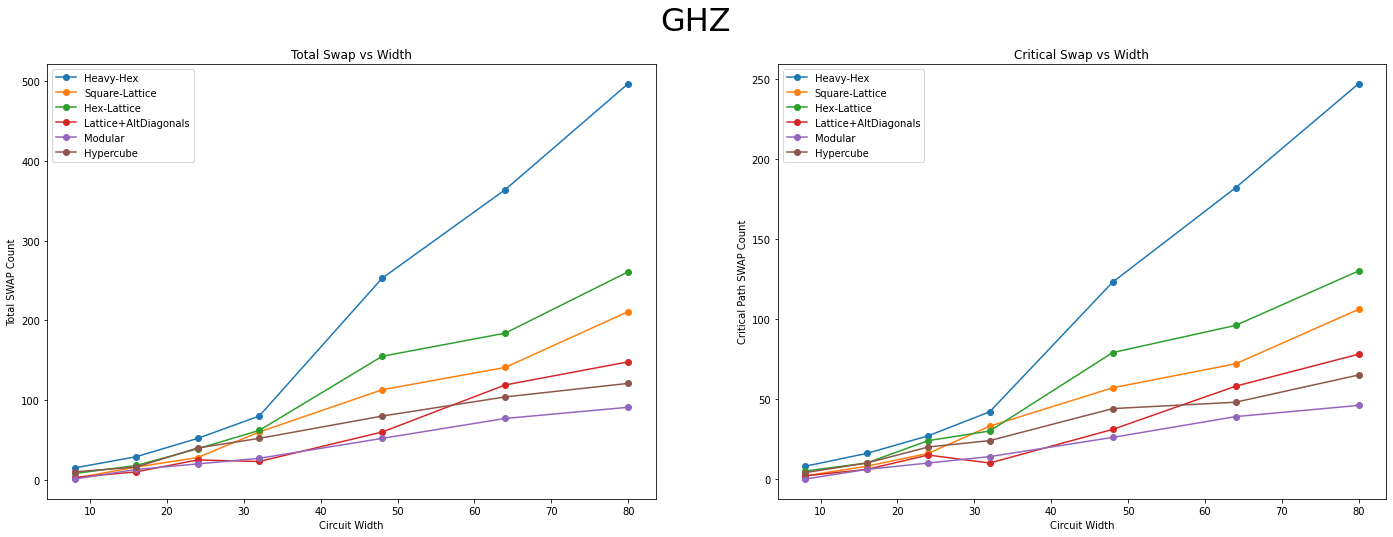

In [18]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits
circuit_gen = circuits["GHZ"]
benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True)
plot(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output='mpl', reverse_bits=True)

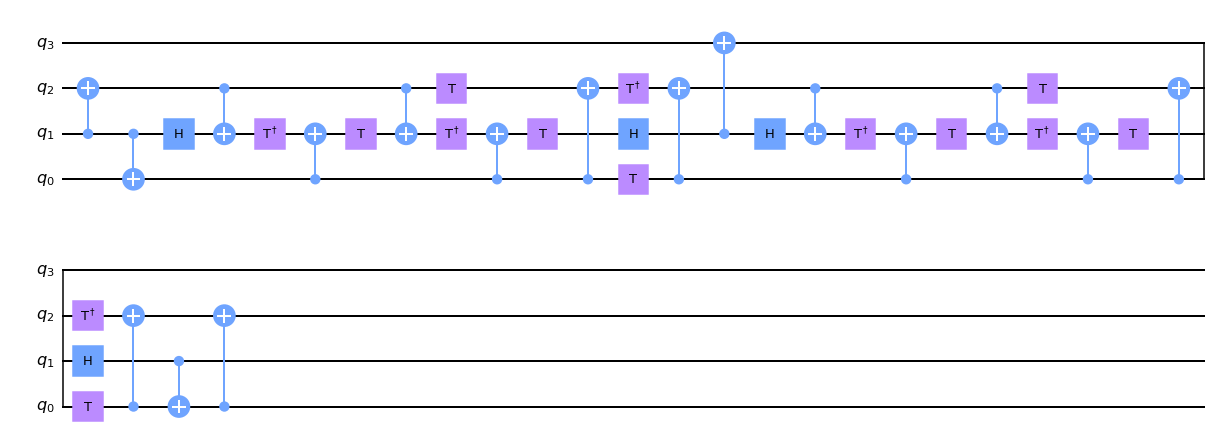

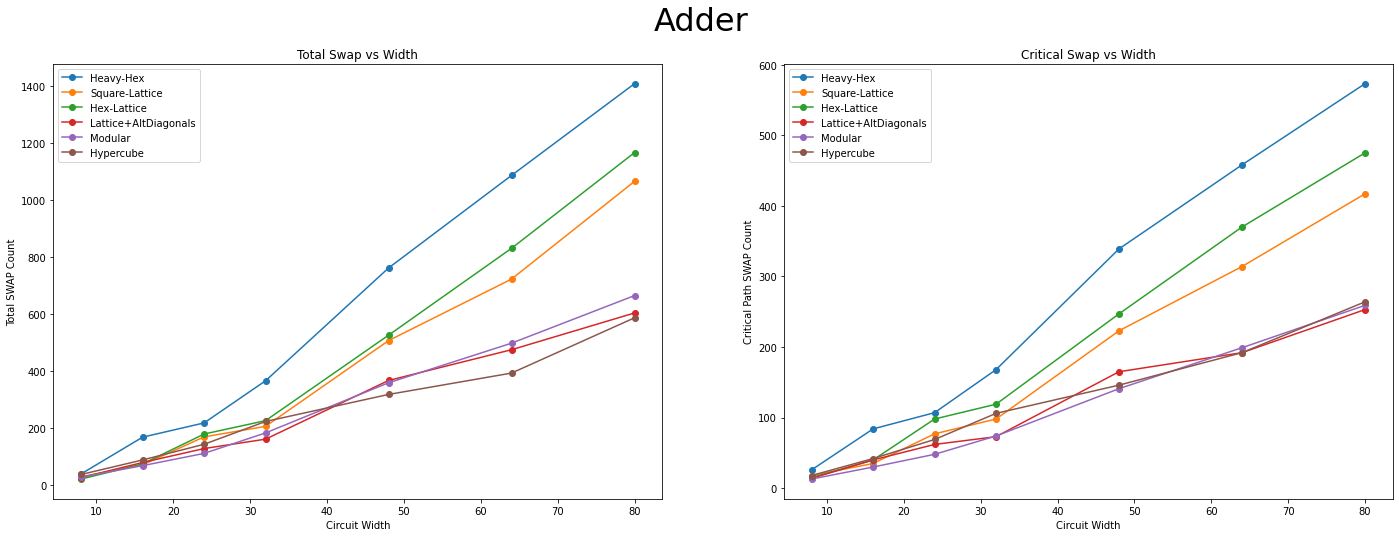

In [19]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits
circuit_gen = circuits["Adder"]
benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True)
plot(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output='mpl', reverse_bits=True)

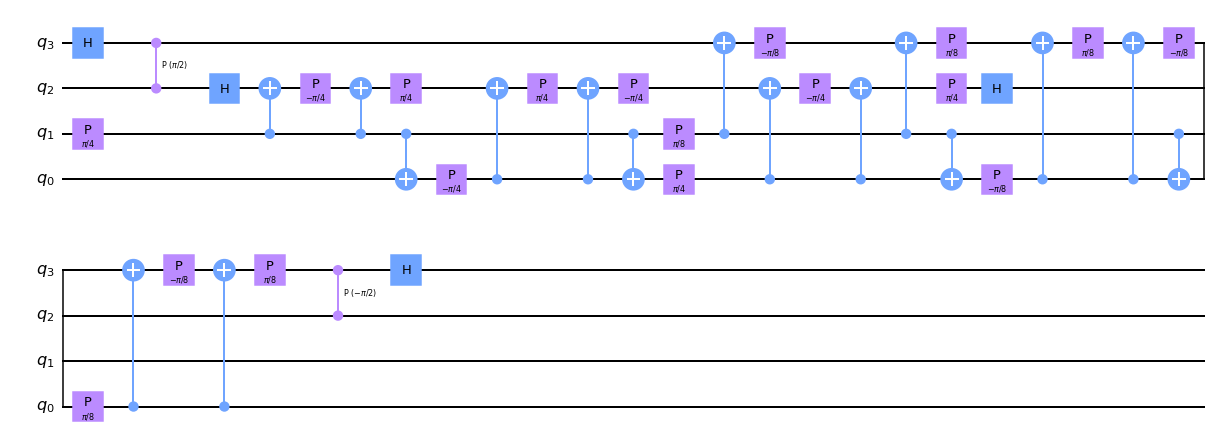

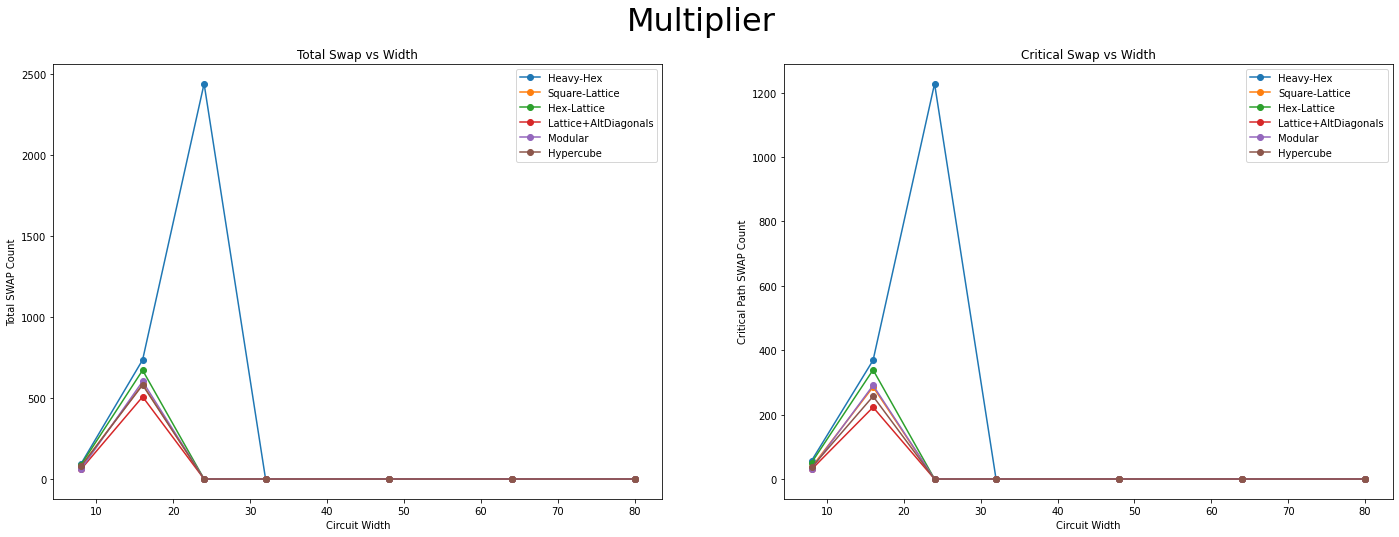

In [20]:
# from backend_suite_v2 import topology_backends
# from circuit_suite import circuits
# circuit_gen = circuits["Multiplier"]
# # circuit_gen.circuit_lambda(8).draw(output='mpl')
# #benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True)
# plot(topology_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).draw(output='mpl', reverse_bits=True)